## Evaluation
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

## Colaboration
Refered to https://www.kaggle.com/code/wti200/analysing-interactions-with-shap issued by *@WTI200*<br>
and https://www.kaggle.com/code/ambrosm/tpsmay22-eda-which-makes-sense/notebook issued by *@AMBROSM*

## Blue print

1. Check data shape and type.
2. Convert chracteristic values to numbers.
3. Split training dataset to *ourtrain* and *ourtest*.
4. Dimensionality reduction.
5. Try various models(logistic regression, decision tree, random forest, SVM, KNN, Naive Bayes).
6. Apply to the test dataset.

## Import Packages

In [46]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [34]:
# Show all columns
pd.set_option("display.max_columns", None)

## 1. Explore Data

In [35]:
# Load dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [36]:
print(train.shape)
train.head()

(900000, 33)


,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,1,3,3,3,1,6,1,0,7,4,0.298218,-0.919717,3.058541,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,4,0,2,3,0,1,0,4,6,0,-3.147667,-1.075434,2.179050,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,2,6,6,4,3,1,2,2,1,4,2.820733,-3.485342,-0.784235,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,1,0,1,6,4,2,3,3,0,3,1.081084,-2.100177,-2.343819,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,0,4,3,0,6,0,3,3,1,0,-0.126179,0.605033,1.133665,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1


In [37]:
# Check data types and missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 33 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      900000 non-null  int64  
 1   f_00    900000 non-null  float64
 2   f_01    900000 non-null  float64
 3   f_02    900000 non-null  float64
 4   f_03    900000 non-null  float64
 5   f_04    900000 non-null  float64
 6   f_05    900000 non-null  float64
 7   f_06    900000 non-null  float64
 8   f_07    900000 non-null  int64  
 9   f_08    900000 non-null  int64  
 10  f_09    900000 non-null  int64  
 11  f_10    900000 non-null  int64  
 12  f_11    900000 non-null  int64  
 13  f_12    900000 non-null  int64  
 14  f_13    900000 non-null  int64  
 15  f_14    900000 non-null  int64  
 16  f_15    900000 non-null  int64  
 17  f_16    900000 non-null  int64  
 18  f_17    900000 non-null  int64  
 19  f_18    900000 non-null  int64  
 20  f_19    900000 non-null  float64
 21  f_20    90

In [38]:
train.describe()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30,target
count,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000
mean,449999.500000,-0.000286,0.001165,0.001174,-0.001368,-0.000571,0.000284,-0.000709,2.031460,2.057998,2.362431,2.177637,1.803392,2.842373,2.239778,1.514686,2.101132,2.096713,1.858518,2.065131,0.308713,-0.178730,-0.156307,-0.009273,-0.369459,-0.342738,0.176549,0.357591,-0.380876,0.345661,1.002654,0.486488
std,259807.765474,0.998888,0.999193,1.000514,1.000175,1.000167,0.999875,0.999942,1.656172,1.590955,1.637706,1.645953,1.537487,1.762835,1.538426,1.359213,1.569093,1.560169,1.467675,1.564783,2.316026,2.400494,2.484706,2.450797,2.453405,2.386941,2.416959,2.476020,238.773054,0.475584,0.818989,0.499818
min,0.000000,-4.599856,-4.682199,-4.642676,-4.658816,-4.748501,-4.750214,-4.842919,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-11.280941,-11.257917,-13.310146,-11.853530,-12.301097,-11.416189,-11.918306,-14.300577,-1229.753052,0.000000,0.000000,0.000000
25%,224999.750000,-0.675490,-0.675162,-0.674369,-0.676114,-0.675909,-0.673437,-0.674876,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-1.236061,-1.804612,-1.820063,-1.645585,-2.019739,-1.955956,-1.440424,-1.261598,-159.427418,0.000000,0.000000,0.000000
50%,449999.500000,0.001144,0.002014,0.002218,-0.002227,-0.001662,-0.000438,-0.001492,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,0.330249,-0.190571,-0.152668,0.030850,-0.390966,-0.340746,0.160912,0.404212,-0.519808,0.000000,1.000000,0.000000
75%,674999.250000,0.674337,0.675021,0.677505,0.672544,0.673789,0.675028,0.674749,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,1.880517,1.444508,1.507071,1.661676,1.255408,1.266673,1.795928,2.028219,158.987357,1.000000,2.000000,1.000000
max,899999.000000,4.749301,4.815699,4.961982,4.454920,4.948983,4.971881,4.822668,15.000000,16.000000,14.000000,14.000000,13.000000,16.000000,12.000000,14.000000,14.000000,15.000000,14.000000,13.000000,12.079667,11.475325,14.455426,11.344080,12.247100,12.389844,12.529179,12.913041,1229.562577,1.000000,2.000000,1.000000


## 2. Investigating Interactions between Features

In [71]:
nums_wTarget = train.columns.to_list()
nums_wTarget.remove('id')
nums_wTarget.remove('f_27')

<AxesSubplot:>

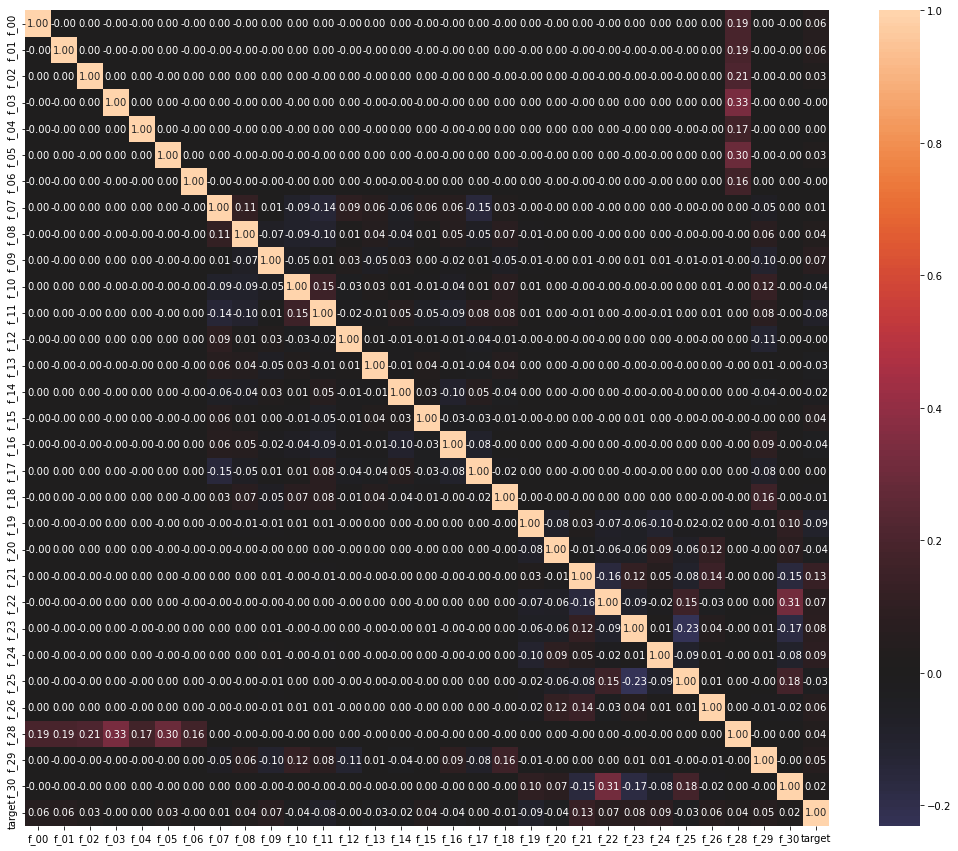

In [73]:
# Check correlations btween numeric values with 'target'

plt.figure(figsize=(18, 15))
sns.heatmap(train[nums_wTarget].corr(), center=0, annot=True, fmt='.2f')

In [43]:
f_02 = train["f_02"]
f_21 = train["f_21"]
hue = train["target"]

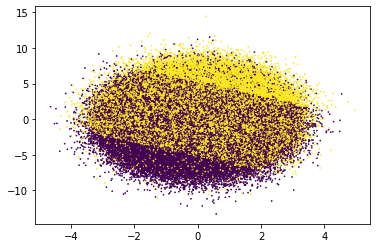

In [45]:
plt.scatter(f_02, f_21, s=0.5, c = hue)

## 2. Trim Characteristic Values

In [4]:
# Check categorical means
f_27 = train.groupby("f_27")
f_27.mean()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30,target
f_27,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAAAAAABAB,202653.0,0.957887,-1.284478,1.379345,1.189851,-0.054777,-1.382964,-0.755519,1.0,2.0,0.0,4.0,7.0,1.0,7.0,1.0,2.0,1.0,4.0,5.0,-1.221429,0.860184,-2.077908,1.582369,-0.020285,-1.917049,0.115874,-6.903443,231.139924,0.0,0.0,0.0
AAAAAAABAC,378487.0,1.212514,0.053393,-0.204789,-1.094622,-0.192677,-0.194913,1.373335,2.0,4.0,0.0,5.0,3.0,2.0,2.0,7.0,1.0,0.0,2.0,0.0,3.917313,0.487382,0.789795,1.191337,2.019059,3.488488,0.412705,0.932727,-116.777037,0.0,2.0,0.0
AAAAAAACAB,549114.0,0.431447,-1.129222,0.492832,0.304130,-0.333223,-0.029821,1.779790,4.0,3.0,2.0,4.0,6.0,2.0,3.0,3.0,1.0,0.0,8.0,2.0,-1.263358,-0.873145,0.113798,-0.157273,4.288482,-2.904971,-1.745038,-1.974924,188.590956,0.0,0.0,0.0
AAAAAAAEAA,19052.0,-0.562865,1.267448,1.207971,-0.018508,-1.565793,-1.746601,1.006371,0.0,1.0,1.0,1.0,3.0,5.0,3.0,4.0,1.0,0.0,1.0,1.0,-0.054453,-1.809019,-3.578063,-0.031663,-2.134586,-5.141280,4.668590,4.692285,279.201865,0.0,2.0,0.0
AAAAAAAEDE,149763.0,0.488868,-0.711647,-0.848438,2.051462,0.036544,0.474993,0.076021,3.0,1.0,4.0,2.0,2.0,0.0,1.0,1.0,1.0,4.0,3.0,0.0,4.216841,-2.797567,-1.057840,-9.964029,-1.658830,1.500818,-2.659704,2.115437,283.429553,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BLBCAAAIBD,442128.0,0.433664,-0.020613,-0.315746,0.551980,-0.262754,0.015910,0.232677,0.0,5.0,1.0,0.0,0.0,3.0,2.0,2.0,0.0,2.0,5.0,0.0,1.392813,-1.196302,1.934514,-0.466950,-3.390553,1.184817,2.798803,2.209411,368.425618,0.0,0.0,0.0
BLBCBBELDC,507163.0,1.453514,1.056128,-0.277299,0.117818,-0.164796,0.377741,-0.433180,1.0,2.0,2.0,1.0,1.0,6.0,3.0,0.0,1.0,2.0,0.0,2.0,1.515484,-1.429957,1.423744,0.499106,-0.613761,1.582238,-2.535053,0.697027,-68.513644,1.0,0.0,0.0
BLBFBBBJDC,838689.0,0.540856,0.296709,-0.793442,-3.012123,-0.284970,-0.341019,-1.270182,0.0,4.0,2.0,0.0,4.0,1.0,6.0,1.0,1.0,4.0,2.0,1.0,3.163585,-1.167505,-1.444005,-0.944610,-2.653502,-2.261654,-1.645269,2.126344,-463.921486,1.0,1.0,0.0


In [31]:
f_27_1 = train[train['target']==1]
print(f_27_1["f_27"].unique().shape)
f_27_1["f_27"].unique()

(390335,)


array(['ACACCADCEB', 'AAAEABCKAD', 'BDBBAACBCB', ..., 'ACABABFNCC',
       'BABBCBBBED', 'BCAACADSCE'], dtype=object)

In [32]:
f_27_0 = train[train['target']==0]
print(f_27_0["f_27"].unique().shape)
f_27_0["f_27"].unique()

(401644,)


array(['ABABDADBAB', 'BDAEDBDEDA', 'BBBDBBEPDB', ..., 'BFBEBBCGCD',
       'BCBBCBCEEB', 'BBBGBBDQBE'], dtype=object)

In [75]:
# Repeated Values
f_27_0["f_27"].value_counts()

BCBBBBCLBC    12
BCBCAABKBB     9
BBBBBBCJBC     9
BBBCCBCBCB     8
ABADBABLAA     8
              ..
BDBCDBDKEE     1
BDBICBBAEC     1
BEADBADRBC     1
AABDABEIED     1
BBBGBBDQBE     1
Name: f_27, Length: 401644, dtype: int64

In [76]:
# Repeated Values
f_27_1["f_27"].value_counts()

ACBABAAJDC    10
BAAACABLBB     8
BAAACACMEB     8
ADBABAANCD     7
ACBABAAHCE     7
              ..
BCBEAABFCB     1
BBBBCAELCF     1
BBBBCBBGGE     1
BAAEEAFQCA     1
BCAACADSCE     1
Name: f_27, Length: 390335, dtype: int64

In [15]:
# train.loc[train['f_27']=='AAAAAAABAC']
sum(train['f_27']=='AAAAAAABAC')

1

In [7]:
# # Drop 'f_27' column
# f_27 = train["f_27"]
# train = train.drop("f_27", axis=1)
# train.shape

(900000, 32)

### - Split train dataset

In [5]:
from sklearn.model_selection import train_test_split
# Drop "id" column as well
Xtr, Xte, Ytr, Yte = train_test_split(train.iloc[:, 1:-1], train["target"], test_size=0.33, random_state=42)

In [9]:
Xtr.shape, Xte.shape, Ytr.shape, Yte.shape

((603000, 30), (297000, 30), (603000,), (297000,))

In [6]:
Xtr.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30
264651,0.373952,-0.192773,-1.554889,0.472246,-0.670936,2.327539,-0.787045,3,4,4,1,0,4,1,2,2,3,5,2,-0.568749,1.641891,-0.739936,1.131147,-2.456995,-1.089577,-2.478166,1.248487,ACBABAANDA,-2.241359,0,2
425708,0.511618,-0.185029,-0.133499,-0.048216,-0.723369,-0.170174,0.198837,1,1,2,4,3,1,2,4,3,1,0,1,4.054068,-2.380203,4.742742,-0.012611,-4.909813,1.378041,0.337883,0.939962,AEBBBACGBF,109.961616,0,1
873268,-0.345388,-0.987766,1.120267,0.058103,0.905351,-0.204358,1.743070,3,3,3,2,0,2,3,0,2,1,1,1,3.264123,1.485585,0.691022,-2.906036,-1.001466,-1.952301,0.746925,-2.419935,BEBBCBCEFF,68.620575,0,0
280958,-1.526159,1.370049,0.461826,-0.580816,1.249378,-0.307775,1.574312,2,1,3,2,3,4,1,1,2,1,0,0,2.346910,1.038364,-2.373643,1.959995,2.178801,-3.670507,-0.516946,1.830878,BABBDBDOBE,240.648673,0,2
332855,0.655890,0.612267,2.686028,-0.339695,1.035081,-0.493066,-0.382761,1,4,8,1,1,4,4,2,2,1,4,0,-2.342403,1.848764,0.121527,-2.500480,3.845254,2.330753,-1.009422,-3.707527,BBBABACRAD,-107.822775,0,1


## 2. Dimensionality Reduction

In [10]:
# Split based on the label
idx_1 = np.where(Ytr==1)
idx_0 = np.where(Ytr==0)

Xtr_1 = Xtr.iloc[idx_1]
Xtr_0 = Xtr.iloc[idx_0]

Ytr_1 = Ytr.iloc[idx_1]
Ytr_0 = Ytr.iloc[idx_0]

### 1) FLDA

In [8]:
def FLDA_fit(A, B):
  # Covariance matrices of the two datasets
  cov1 = np.cov(A.T)
  cov2 = np.cov(B.T)
  cov_tot = (cov1+cov2)/2

  # Mean of the two datasets
  mean1 = A.mean(0)
  mean2 = B.mean(0)
  mean_diff = np.atleast_1d(mean1-mean2)

  return np.linalg.solve(cov_tot, mean_diff)

def FLDA_proj(X, w):
    Xproj = X.dot(w)
    Xproj1 = Xproj.iloc[idx_1]
    Xproj0 = Xproj.iloc[idx_0]
    return Xproj, Xproj1, Xproj0

In [11]:
# Fit the data
flda_w = FLDA_fit(Xtr_1, Xtr_0)

# Project
Xtr_proj, Xtr_proj1, Xtr_proj0 = FLDA_proj(Xtr, flda_w)
Xte_proj = Xte.dot(flda_w)

This is not linearly separable.


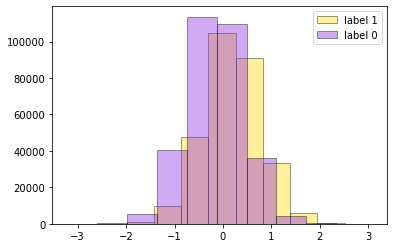

In [13]:
plt.hist(Xtr_proj1, color='gold', ec='black', label="label 1", alpha=0.4)
plt.hist(Xtr_proj0, color='blueviolet', ec='black', label="label 0", alpha=0.4)
plt.legend()
print("This is not linearly separable.")

### 2) PCA

Text(0, 0.5, 'Expained ratio')

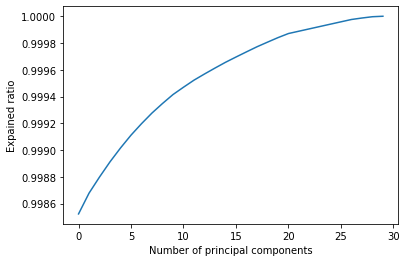

In [14]:
from sklearn.decomposition import PCA
pca = PCA().fit(Xtr)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of principal components")
plt.ylabel("Expained ratio")

In [15]:
# Try with 2 PCs
pca = PCA(n_components=2)
pca.fit(Xtr)
Xtr_pca1 = pca.transform(Xtr_1)
Xtr_pca0 = pca.transform(Xtr_0)

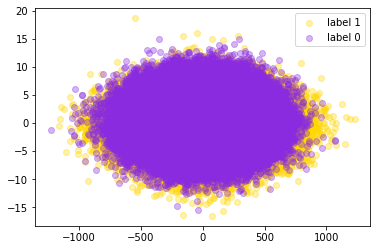

This is not linearly separable.


In [16]:
plt.scatter(Xtr_pca1[:, 0], Xtr_pca1[:, 1], color='gold', alpha=0.35, label="label 1")
plt.scatter(Xtr_pca0[:, 0], Xtr_pca0[:, 1], color='blueviolet', alpha=0.35, label="label 0")
plt.legend()
plt.show()

print("This is not linearly separable.")

In [17]:
# Try with 3 PCs
pca = PCA(n_components=3)
pca.fit(Xtr)
Xtr_pca1 = pca.transform(Xtr_1)
Xtr_pca0 = pca.transform(Xtr_0)

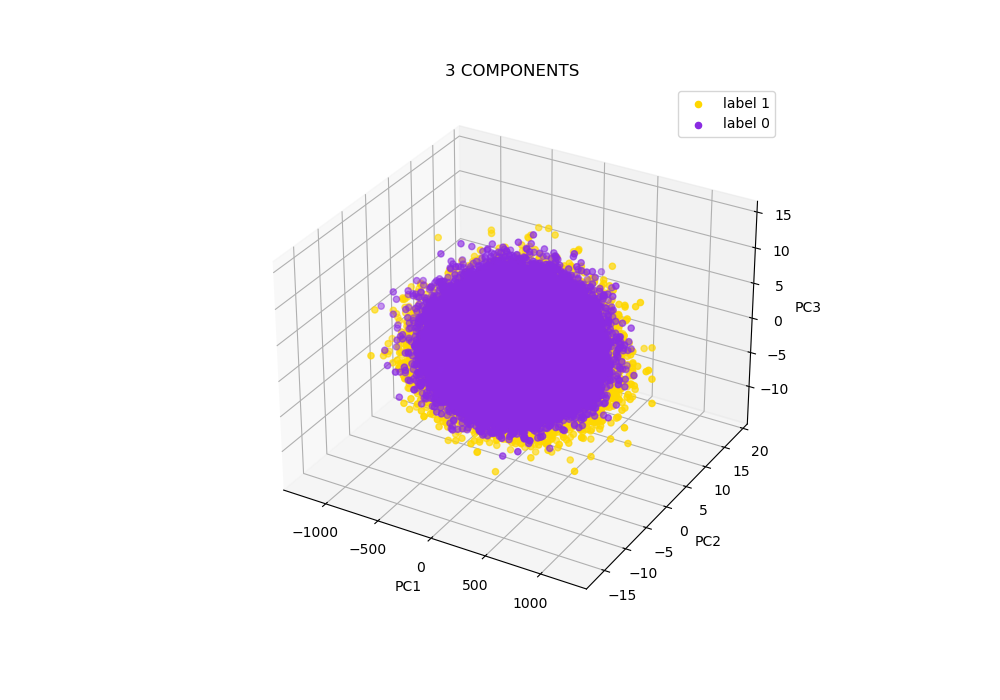

In [18]:
# 3D Plotting
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

fig3d = plt.figure(figsize = (10, 7))
ax3d = plt.axes(projection='3d')

ax3d.scatter(Xtr_pca1[:, 0], Xtr_pca1[:, 1], Xtr_pca1[:, 2], c = 'gold', label = "label 1")
ax3d.scatter(Xtr_pca0[:, 0], Xtr_pca0[:, 1], Xtr_pca0[:, 2], c = 'blueviolet', label = "label 0")

ax3d.set_title("3 COMPONENTS")
ax3d.set_xlabel("PC1")
ax3d.set_ylabel("PC2")
ax3d.set_zlabel("PC3")

plt.legend() 
plt.show()

In [19]:
# We will use 2 PCs
pca = PCA(n_components=2)
pca.fit(Xtr)
Xtr_pca = pca.transform(Xtr)
Xte_pca = pca.transform(Xte)

### 3) Kernel Approximation - Higher Dimension

In [20]:
from sklearn.kernel_approximation import RBFSampler

# RBF
rbf_feature = RBFSampler(gamma=1, random_state=1)
Xtr_rbf = rbf_feature.fit_transform(Xtr)
Xte_rbf = rbf_feature.fit_transform(Xte)

In [21]:
from sklearn.kernel_approximation import Nystroem

# Nystroem
nys_feature = Nystroem(gamma=0.2, random_state=1)
Xtr_nys = nys_feature.fit_transform(Xtr)
Xte_nys = nys_feature.fit_transform(Xte)

## 3. Model Application

### 1) SVM

In [25]:
from sklearn.svm import SVC
SVC_PCA= make_pipeline(StandardScaler(), SVC(gamma='auto'))

# Fit
SVC_PCA.fit(Xtr_pca, Ytr)

# Predict
Y_SVC = SVC_PCA.predict(Xte_pca)

# Check ROC score
roc_auc_score(Yte, Y_SVC)

### 2) SGD Classifier

In [ ]:
from sklearn.linear_model import SGDClassifier
SGC_clf = make_pipeline(StandardScaler(), SGDClassifier(loss='log'))

# Fit
SGC_clf.fit(Xtr, Ytr)     # Using original data
# SGC_clf.fit(Xtr_rbf, Ytr)   # using kernel approximation
# SGC_clf.fit(Xtr_nys, Ytr)

# Predict
Y_SGCclf = SGC_clf.predict(Xte)
# Y_SGCclf = SGC_clf.predict(Xte_rbf)
# Y_SGCclf = SGC_clf.predict(Xte_nys)

# Check ROC score
roc_auc_score(Yte, Y_SGCclf)    # Poor!

### 3) SGD Regressor

In [ ]:
# Fit

In [ ]:
# Predict

In [ ]:
# Check ROC score